In [124]:
%reset -f 
%matplotlib inline
import numpy as np
from matplotlib.animation import FuncAnimation
import os, sys, importlib, json, itertools
from datetime import datetime
from IPython.display import HTML, display
import matplotlib.image as mpimg
import pandas as pd

# Import the aif module
pwd = os.path.abspath('') + "/"
sys.path.insert(1, pwd + '/aif_catkin_ws/aif_gazebo/scripts/simulation_methods')
import aif_functions_iterative_sampling as aif # Interchangeable with aif_functions_isobeliefs and aif_functions_isobeliefs_mcts
# import aif_catkin_ws.aif_gazebo.scripts.aif_functions_isobeliefs_adaptable as aif # Interchangeable with aif_functions_isobeliefs and aif_functions_isobeliefs_mcts
importlib.reload(aif)

import os
print(os.cpu_count())

8


In [127]:
# Re-define the environment and simulation parameters here
interactive = False  # Set to True to display the animation in the notebook
fast_plot = True  # Set to True to plot the results faster
use_ep = False  # Set to True to use EP, False to use the standard algorithm
convergence_type = 'exclusive'  # Set to 'converge' to check for convergence, 'exclusive' to check for separate goals
args = {}
draft_results = []

random_seed = 1  #39 is good too! 2 goals, 3 agents (actually 39 is perfect) 2 looks good for 10 goals, 3 agents
# 3 seed is good for 10 goals, 3 agents with both EP set to True and False environment size 30
# 5 seed is good for 20 goals, 5 agents with both EP set to True and False environment size 50 -- really good
np.random.seed(random_seed)  # Set random seed
# Set random goals
env_size = 30  # Environment size
iterations_per_episode = 150  # Number of iterations per episode
num_goals = 20 # Number of goals
num_agents = 4 # Number of agents
list_types = ['A','B']
goals = np.random.uniform(1,env_size-1,size=(num_goals, 2))  # Goal positions
# goals = np.array([[0,0],[env_size-5,0]], dtype=float)  # Goal positions
agent_positions = np.hstack((np.ones((1,1))*(num_agents-1) + np.random.randn(num_agents,2), np.zeros((num_agents,1))))  # Initial agent positions
number_of_heading_options = 8; number_of_velocity_options = 4
args = dict({
    'goals': goals, # Goal positions
    'home_base': np.array([0,0]), # Home base position
    'agent_types': np.random.choice(list_types,num_agents), # Agent types
    'agent_positions': agent_positions, # Initial agent positions
    'velocity_options': np.linspace(0.1,1,number_of_velocity_options,endpoint=True), # Velocity options
    'num_heading_options': number_of_heading_options, # Number of heading options
    'heading_options': np.linspace(-np.pi/4,np.pi/4,number_of_heading_options,endpoint=True),
    'observation_error_std': 0.5, # Observation error standard deviation
    'num_actions': number_of_heading_options*number_of_velocity_options, # Number of actions
    'env_size': env_size, # Environment size
    'max_distance_measure': env_size + 20,
    'max_heading_measure': np.pi, # Maximum heading measure
    'prior': np.ones(agent_positions.shape[0]) / agent_positions.shape[0], # Prior belief
    'use_ep': use_ep, # Use epistemic planning (2nd order reasoning)
    'horizon': 5, # Horizon for free energy checking
    'mcts_iterations': 100, # Number of MCTS iterations
    'use_mcts': False,
    'use_rhc': False,
    'use_threading': False, #TODO: Implement threading
    'greedy': False, # Greedy action selection
    'convergence_type': convergence_type, # Convergence type
    'dt': 1, # Time step
})

# tuple_elements = [i for i in range(agent_positions.shape[0])]
# configurations = list(itertools.permutations(tuple_elements))
# args['reward_configs'] = np.array(configurations) # Reward configurations if different goals
# Run the simulation
results = aif.run_simulation(args, iterations_per_episode)

Iteration 115: Total execution time: 3.92s
Agents have converged after 115 iterations with average execution time of 0.034119734556778615s.


Image saved as:  c:\Users\qbr5kx\OneDrive - University of Virginia\Desktop\UVA\PhD Scratch\Active_Epistemic_Inference\aif_multi_robot/videos/Converged_numRobots4_numGoals20_seed1_EPFalse_goalTypeexclusive_greedyFalse_envSize30.mp4


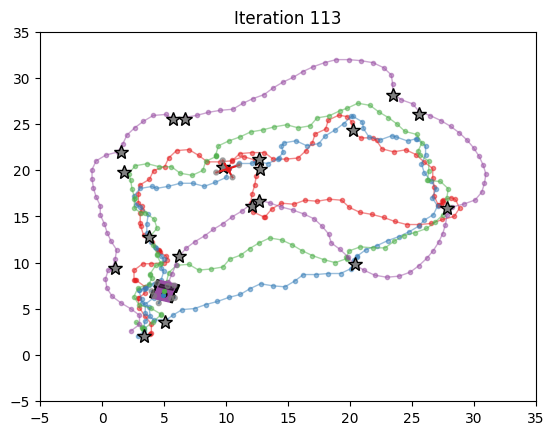

In [128]:

# draft_results.append([random_seed, results['converged'], num_goals, num_agents, args['agent_types'], 
#                         use_ep ,results['iteration']])
    
#     print("-------------------")
#     print("\rPercentage Complete: ", count/max_iterations*100, "%", end="")
#     print("-------------------")
#     count += 1

# Save the results
# current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
# df = pd.DataFrame(draft_results, columns=['seed','converged','num_goals','num_agents','agent_types','use_ep','num_iters'])    T
#                convergence_type, "_greedy", args['greedy'], "_envSize", env_size]
# Create animation
if not fast_plot:
    if convergence_type == 'converge':
        completed_task_img = mpimg.imread('figures/meeting_icon_selected_ep.png')
        not_completed_task_img = mpimg.imread('figures/meeting_icon_not_selected_ep.png')
    else:
        completed_task_img = mpimg.imread('figures/fire_icon.png')
        not_completed_task_img = mpimg.imread('figures/fire_icon.png')

    plt_sim = aif.PlotSim(num_agents, goals, args['agent_types'], completed_task_img, not_completed_task_img, env_size, padding=5, scale = 0.5)
else:
    plt_sim = aif.PlotSim_fast(num_agents, goals, args['agent_types'],env_size, padding=5, scale = 0.5)
ani = FuncAnimation(plt_sim.fig, plt_sim.update, frames=range(results['iteration']), init_func=plt_sim.init, fargs = (results['plot_args'],), blit=True, repeat=True)

# Save the animation as a video
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
config_file = ["numRobots", num_agents, "_numGoals", num_goals, "_seed", random_seed, "_EP", args['use_ep'], "_goalType", convergence_type, 
               "_greedy", args['greedy'], "_envSize", env_size]
config_file = ''.join([str(elem) for elem in config_file])
if results['converged'] == None and not interactive:
    filepath = pwd + "videos/NO_convergence_" + config_file + ".mp4"
    ani.save(filepath, writer='ffmpeg', fps=3, dpi=500)
    # Save location of the final image
    print("Image saved as: ", filepath)
elif not interactive:
    filepath = pwd + "videos/path_only/Converged_" + config_file + ".mp4"
    ani.save(filepath, writer='ffmpeg', fps=3, dpi=500)
    # Save location of the final image
    print("Image saved as: ", filepath)
else:
    display(HTML(ani.to_jshtml())) # Use an interactive backend for animation




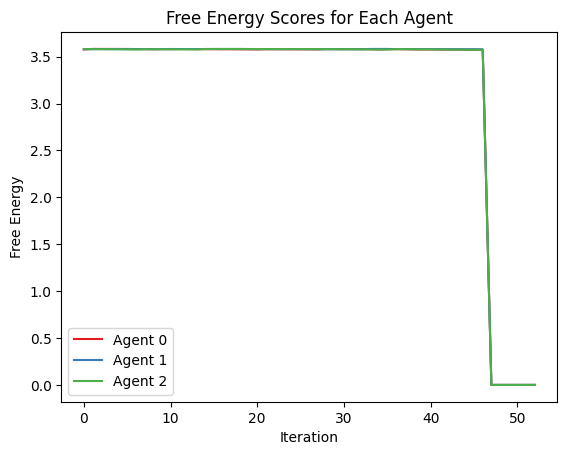

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


In [95]:
avg_nrg_over_time = results['energy_scores']
num_frames = results['iteration']
energy_results, ending_energy = aif.parse_free_energy_scores(avg_nrg_over_time, num_frames)
aif.plot_energy(energy_results, num_agents)
print(args['reward_configs'])

In [ ]:
# Calculate distance to final goals
final_distances = np.zeros((num_agents, goals.shape[0]))
for i in range(num_agents):
    for j in range(goals.shape[0]):
        final_distances[i,j] = np.linalg.norm(results['positions'][i,:2] - goals[j,:])
print("Final distances: ", final_distances)


Final distances:  [[0.04272534 4.99155181]
 [0.04607108 5.04569454]]


In [27]:
# Scratch code for testing

goals = np.array([[0,0],[0.,10.]])
my_pose = np.array([0, 4])
other_pose = np.array([0, 5])
saliences = np.zeros(goals.shape[0])
goal_azimuths = np.arctan2(goals[:, 1] - my_pose[1], goals[:, 0] - my_pose[0])
observed_azimuth = np.arctan2(my_pose[1] - other_pose[1], my_pose[0] - other_pose[0])
relative_azimuths = np.abs((goal_azimuths - observed_azimuth + np.pi) % (2 * np.pi) - np.pi)
azimuth_salience = 1./8 * np.exp(- relative_azimuths / np.pi)  # normalize and invert to make smaller angles more salient
saliences += azimuth_salience
# Compute if observed robot is heading towards the goal
# heading_to_goal = (np.arctan2(goals[:, 1] - observation['position'][1], goals[:, 0] - observation['position'][0]) - observation['heading'] + np.pi) % (2 * np.pi) - np.pi
# heading_salience = 1./8 * np.exp(- np.abs(heading_to_goal) / np.pi)
# saliences += heading_salience


print("Goal Azimuth: ", goal_azimuths)
print("Relative Azimuth: ", azimuth_salience)
print("Observed Azimuth: ", observed_azimuth)
print("Salience: ", saliences)
# print("Heading Salience: ", heading_salience)
print(np.exp(0.8/np.pi))

Goal Azimuth:  [-1.57079633  1.57079633]
Relative Azimuth:  [0.125      0.04598493]
Observed Azimuth:  -1.5707963267948966
Salience:  [0.125      0.04598493]
1.2900073408606396


In [ ]:
poses = np.array([[0,0],[0,0]])+0.5
print(poses)
distance = sum(poses[i][dim] - poses[j][dim] for i in range(2) for j in range(2) if i != j for dim in range(2))
1e4 / (1+np.exp(100*(distance - 1.5)))

[[0.5 0.5]
 [0.5 0.5]]


10000.0